# 1083 Albumin Initial ML

### By: Ian Weimer

## Imports

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
import math
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import cross_val_score
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
import warnings
from sklearn.compose import make_column_transformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import balanced_accuracy_score
import graphviz
import pydotplus
from imblearn.over_sampling import SMOTE, SMOTENC
pd.set_option('display.max_columns', None)

## Load Albumin Data From Pre-processing and Exploratory Analysis

In [2]:
df = pd.read_csv('N04_matched_1.csv')

In [3]:
# drop insignificant vars

#df.drop(columns = ['bed_size', 'Cirrhosis', 'tenant'], inplace=True)

In [4]:
df.head()

encounterid  ICU  Cirrhosis  CCI  qSOFA  SEWS  \
0  1684f4f6-2f4a-4441-8af9-c4165f550d54    0          0    0      1     2   
1  8a39cae9-5cb0-4aa6-9d0c-dd11d86d3b09    0          0    1      0     0   
2  6a0962cf-b9f7-4c4f-ba75-fc5207722a36    0          1    0      1     2   
3  3639f1d7-780b-4766-b9e5-b70db8f617b5    0          0    0      1     3   
4  59c8a1ba-0aa9-4a0e-9764-d96eb5a2df03    0          0    4      1     3   

   diuretic  propensity_score  propensity_logit  albumin_24hrs  \
0         1          0.771511          1.216863              1   
1         1          0.551220          0.205600              1   
2         1          0.910373          2.318201              1   
3         1          0.788312          1.314781              1   
4         1          0.727234          0.980636              1   

                               personid  LOS_days  90_day_mortality  \
0  0bd4cf71-9232-4d6c-bb76-b580a813d0b8  0.743750                 0   
1  21b88c50-de34-435d-8c60-357d6d8ca892  6.963056                 0   
2  40cd7ee5-00d8-45af-8781-7ea6e956d8e9  4.140972                 0   
3  48531d48-8a10-46f1-b80d-252e08c651cd  1.348611                 0   
4  6ee7780f-14d7-4733-a47f-0b6c97e32870  9.985417                 0   

   90_day_readmission  hospital_free_days  albumin_timing  albumin  
0                 1.0                  36             1.0        1  
1                 0.0                  83             2.0        1  
2                 0.0                  14             2.0        1  
3                 0.0                   4             1.0        1  
4                 1.0                   9             2.0        1

In [5]:
df.shape

(3140, 17)

## Select Only Patients Who Lived (Removing Patients in 0 Class Who Died)

In [6]:
df = df.loc[df['90_day_mortality'] == 0]

In [7]:
df.shape

(2950, 17)

## Look at outcomes distributions between patients who did and didn't receive albumin within 24 hrs

In [8]:
ra_90d_a24 = df[df['albumin_24hrs'] == 1]['90_day_readmission'].value_counts()
print(ra_90d_a24)

0.0    822
1.0    632
Name: 90_day_readmission, dtype: int64


In [9]:
def binary_pct(var):
    pct = (var[1]/(var[1]+var[0])) * 100
    return pct

binary_pct(ra_90d_a24)

43.46629986244842

In [10]:
ra_90d = df[df['albumin_24hrs'] == 0]['90_day_readmission'].value_counts()
print(ra_90d)

0.0    846
1.0    650
Name: 90_day_readmission, dtype: int64


In [11]:
binary_pct(ra_90d)

43.44919786096257

In [12]:
df.drop(columns=['propensity_score', 'propensity_logit', 'encounterid', 'personid', 'albumin', 'albumin_timing'], inplace=True)

In [13]:
df.drop(columns=['90_day_mortality', 'LOS_days', 'hospital_free_days'], inplace=True)

In [14]:
# remove variables

# df.drop(columns=['mass_transfusion', 'anemia_status', 'qSOFA', 'hemorrhagic', 'bl_albumin_value', 'SAPS'], inplace=True)
# df.drop(columns=['qSOFA', 'bl_albumin_value', 'SAPS'], inplace=True)

In [15]:
df.describe()

ICU    Cirrhosis          CCI        qSOFA         SEWS  \
count  2950.000000  2950.000000  2950.000000  2950.000000  2950.000000   
mean      0.103051     0.222712     2.877288     0.435254     1.174237   
std       0.304077     0.416137     2.639629     0.584975     1.482627   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     3.000000     0.000000     1.000000   
75%       0.000000     0.000000     5.000000     1.000000     2.000000   
max       1.000000     1.000000    18.000000     3.000000     9.000000   

          diuretic  albumin_24hrs  90_day_readmission  
count  2950.000000    2950.000000         2950.000000  
mean      0.937627       0.492881            0.434576  
std       0.241873       0.500034            0.495785  
min       0.000000       0.000000            0.000000  
25%       1.000000       0.000000            0.000000  
50%       1.000000       0.000000            0.000000  
75%       1.000000       1.000000            1.000000  
max       1.000000       1.000000            1.000000

In [16]:
#df = df[['CCI', 'unknown_albumin_type', 'albumin_24hrs', '25_percent_albumin', 'LOS_days']]

## Modeling

In [17]:
# establish target feature, LOS_days, as y feature
y = df['90_day_readmission']
# drop target feature from features dataframe
X = df.drop(columns = ['90_day_readmission'], axis = 1)
# save dataframe column titles to list for reassigning after min max scale 
cols = X.columns

In [18]:
cols

Index(['ICU', 'Cirrhosis', 'CCI', 'qSOFA', 'SEWS', 'diuretic',
       'albumin_24hrs'],
      dtype='object')

## Standardize Data

In [19]:
#cols = X.columns

#instantiate min-max scaling object
#mm = MinMaxScaler()
# fit and transform feature dataframe
#X = pd.DataFrame(mm.fit_transform(X))
# reassign column names so new dataframe has corresponding names
#X.columns = cols

In [20]:
X.head()

ICU  Cirrhosis  CCI  qSOFA  SEWS  diuretic  albumin_24hrs
0    0          0    0      1     2         1              1
1    0          0    1      0     0         1              1
2    0          1    0      1     2         1              1
3    0          0    0      1     3         1              1
4    0          0    4      1     3         1              1

## Train Test Split

In [21]:
sm = SMOTENC(random_state=42, categorical_features = [0, 1, 3, 5])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [22]:
#sm = SMOTEN(random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#X_train, y_train = sm.fit_resample(X_train, y_train)

In [23]:
y_train.value_counts()

1.0    1340
0.0    1340
Name: 90_day_readmission, dtype: int64

In [24]:
# train test split from target feature series and the predicting feature dataframe (set test size to 20% of data)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 33)

## Multinomial Logistic Regression

In [25]:
# instantiate a Logistic Regression model without an intercept, 'liblinear' solver method
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# fit the model to X and y training sets
logreg.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

Feature: ICU Score: 0.03419
Feature: Cirrhosis Score: -0.00133
Feature: CCI Score: 0.04732
Feature: qSOFA Score: -0.02591
Feature: SEWS Score: -0.01277
Feature: diuretic Score: 0.08718
Feature: albumin_24hrs Score: 0.00542


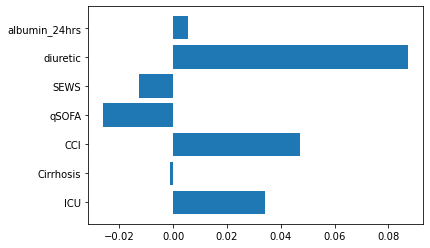

In [26]:
# general quick feature importance
# get coefficients for importance
# coefficients represent the log odds that an observation is in the
# target class, given the values of its X variables

importance = logreg.coef_[0]
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

               Importance
diuretic         1.091098
CCI              1.048457
ICU              1.034784
albumin_24hrs    1.005439
Cirrhosis        0.998668
SEWS             0.987307
qSOFA            0.974421


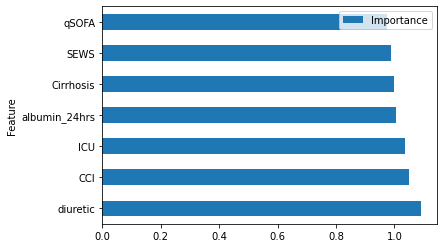

In [27]:
# convert log odds into regular odds with exponentiation
# np.exp()
# and list values, visualize in bar plot

odds = np.exp(logreg.coef_[0])
feature_importance = \
            pd.DataFrame(odds, 
             X.columns, 
             columns=['Importance'])\
            .sort_values(by='Importance', ascending=False)
        
ax = feature_importance.plot.barh(xlabel='Feature', ylabel='Importance')
print(feature_importance)
plt.show()

In [28]:
# Generate model prediction data for train and test sets
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

In [29]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[803 537]
 [653 687]]


In [30]:
# model metrics for training set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

         0.0       0.55      0.60      0.57      1340
         1.0       0.56      0.51      0.54      1340

    accuracy                           0.56      2680
   macro avg       0.56      0.56      0.56      2680
weighted avg       0.56      0.56      0.56      2680



In [31]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[181 147]
 [120 142]]


In [32]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

         0.0       0.60      0.55      0.58       328
         1.0       0.49      0.54      0.52       262

    accuracy                           0.55       590
   macro avg       0.55      0.55      0.55       590
weighted avg       0.55      0.55      0.55       590



## 5: Decision Tree 

In [33]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)

Feature: ICU Score: 0.00000
Feature: Cirrhosis Score: 0.03508
Feature: CCI Score: 0.70113
Feature: qSOFA Score: 0.00000
Feature: SEWS Score: 0.22354
Feature: diuretic Score: 0.00000
Feature: albumin_24hrs Score: 0.04025


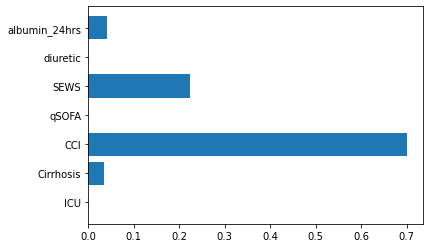

In [34]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [35]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [36]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[728 612]
 [545 795]]


In [37]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

         0.0       0.57      0.54      0.56      1340
         1.0       0.57      0.59      0.58      1340

    accuracy                           0.57      2680
   macro avg       0.57      0.57      0.57      2680
weighted avg       0.57      0.57      0.57      2680



In [38]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[172 156]
 [119 143]]


In [39]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

         0.0       0.59      0.52      0.56       328
         1.0       0.48      0.55      0.51       262

    accuracy                           0.53       590
   macro avg       0.53      0.54      0.53       590
weighted avg       0.54      0.53      0.54       590



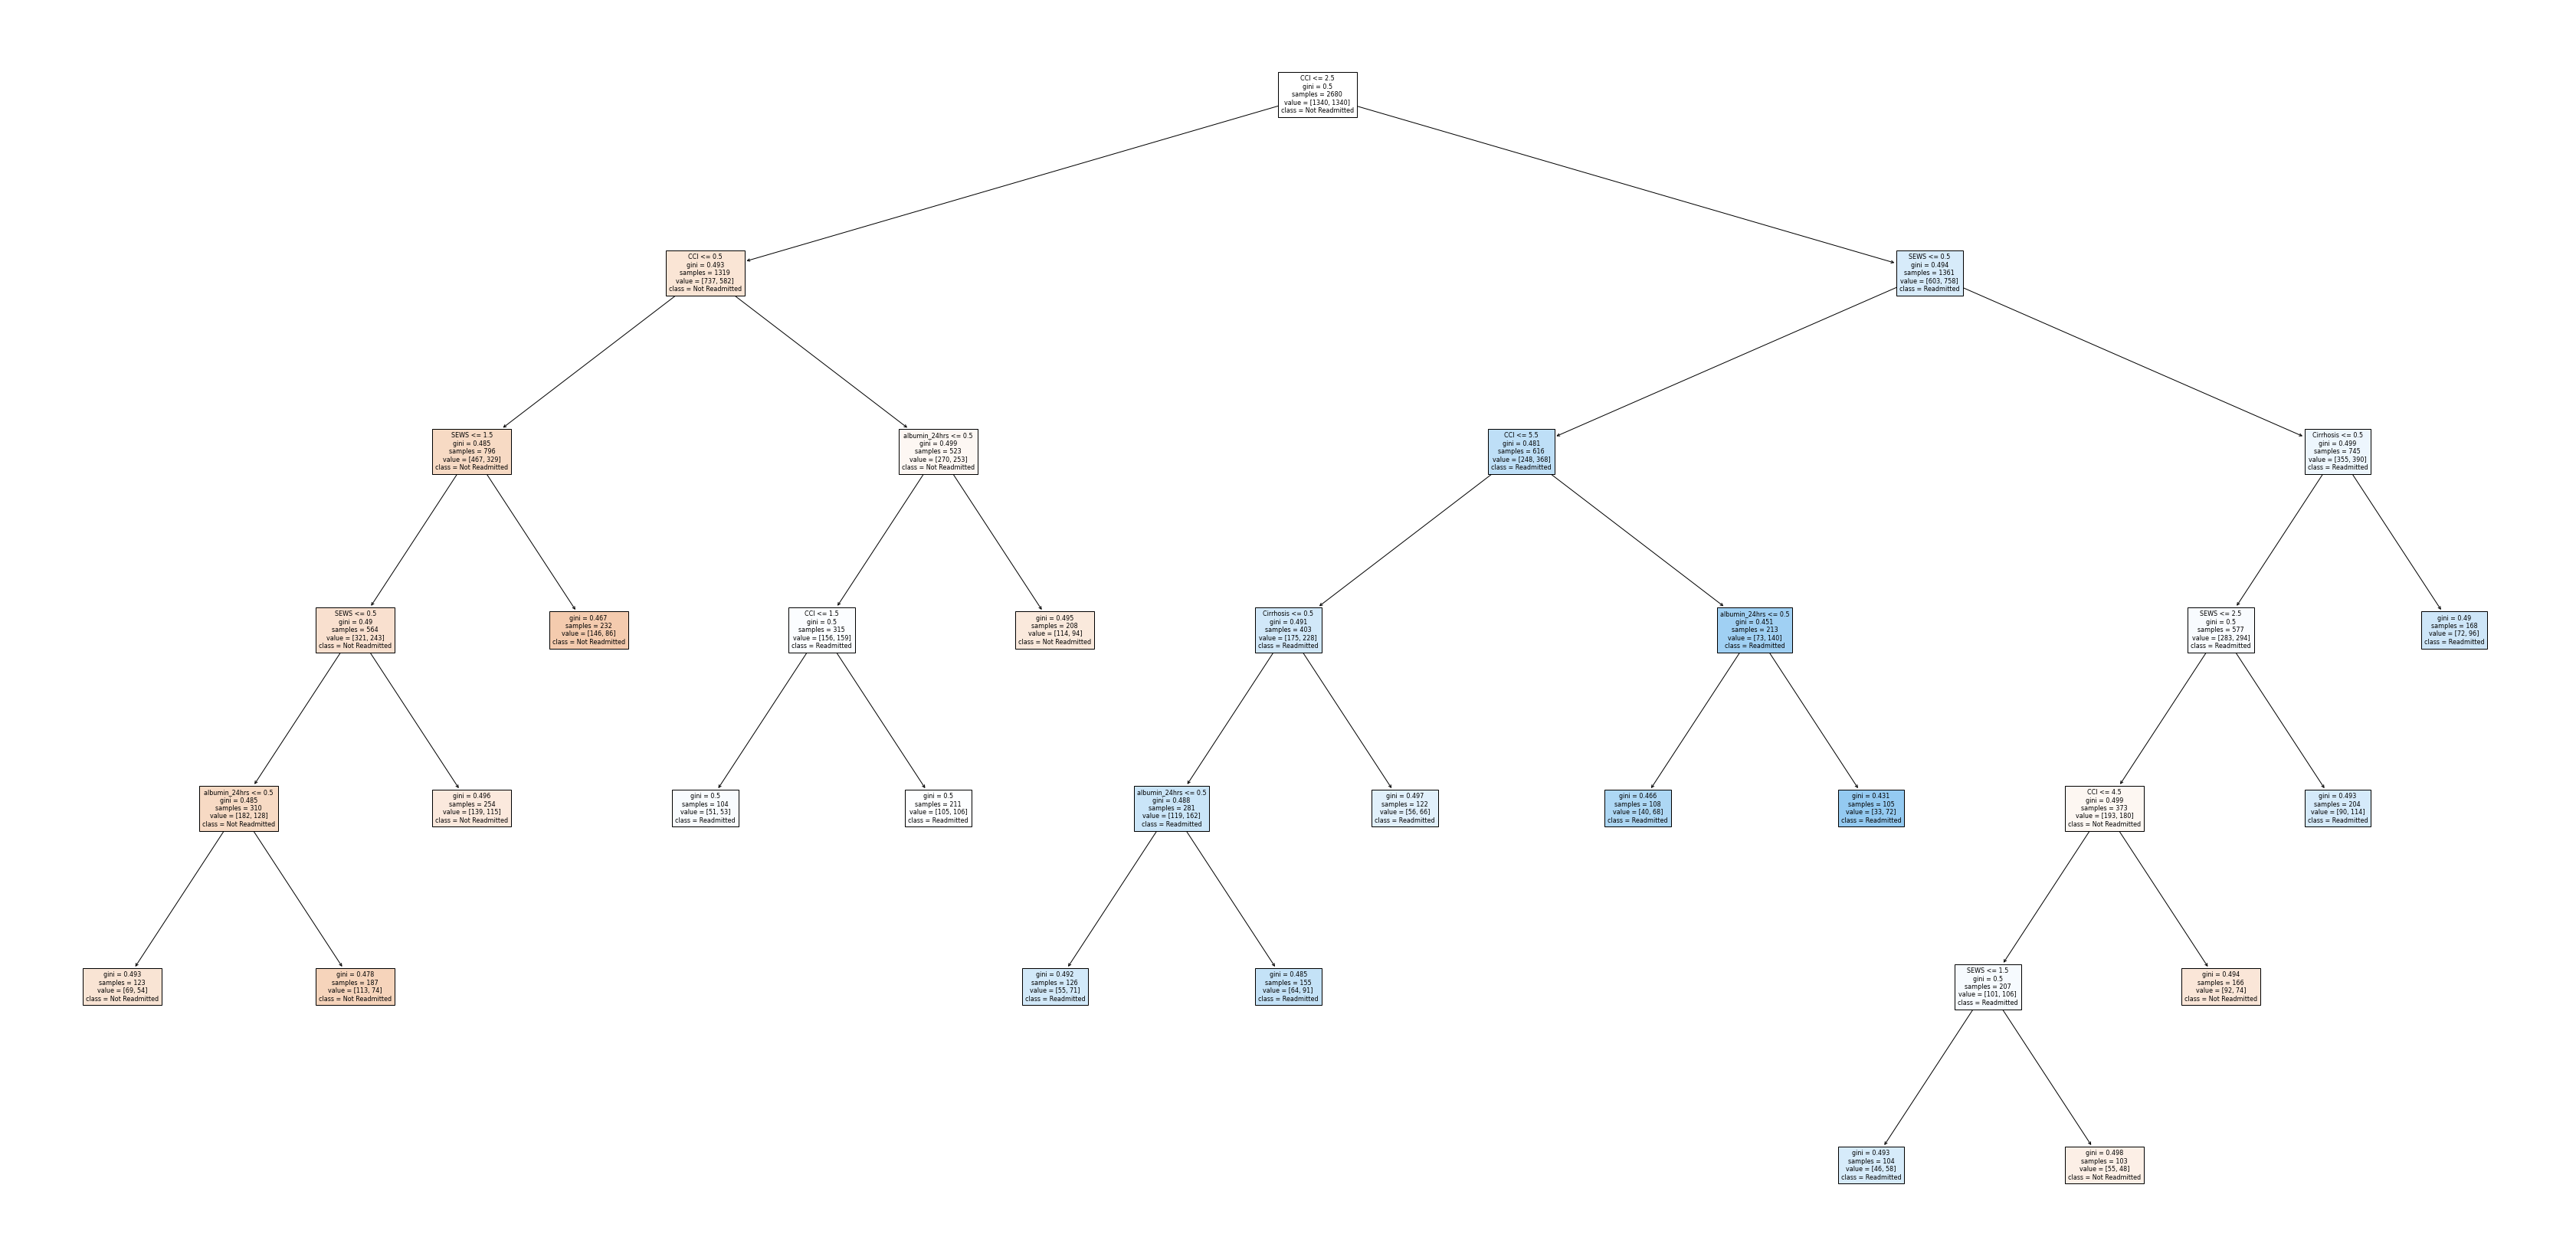

In [40]:
feature_names = X_train.columns.tolist()
class_names = ['Not Readmitted', 'Readmitted']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [41]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('90DRA_DT_D7_PSM_MATCHED_1.png')

True

## Random Forest

In [42]:
rf = RandomForestClassifier(max_depth=8, min_samples_leaf=100)
# fit the model to X and y training sets
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=100)

In [43]:
# generate model prediction data for train and test sets
y_hat_train = rf.predict(X_train)
y_hat_test = rf.predict(X_test)

In [44]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[730 610]
 [545 795]]


In [45]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

         0.0       0.57      0.54      0.56      1340
         1.0       0.57      0.59      0.58      1340

    accuracy                           0.57      2680
   macro avg       0.57      0.57      0.57      2680
weighted avg       0.57      0.57      0.57      2680



In [46]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[161 167]
 [109 153]]


In [47]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

         0.0       0.60      0.49      0.54       328
         1.0       0.48      0.58      0.53       262

    accuracy                           0.53       590
   macro avg       0.54      0.54      0.53       590
weighted avg       0.54      0.53      0.53       590



Feature: ICU Score: 0.01229
Feature: Cirrhosis Score: 0.06167
Feature: CCI Score: 0.62698
Feature: qSOFA Score: 0.06838
Feature: SEWS Score: 0.14724
Feature: diuretic Score: 0.00799
Feature: albumin_24hrs Score: 0.07545


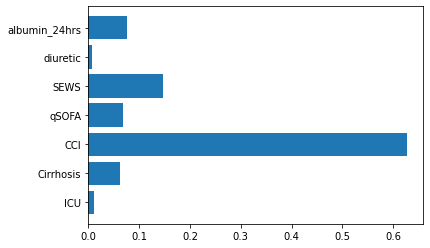

In [48]:
# get importance from decision tree model
importance = rf.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()